Gaussian Process

In [2]:
%pip freeze | findstr "numpy scipy"

numpy==2.0.2
scipy==1.13.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np

data = np.loadtxt('./data/input.data')

print(data.shape)
print(data[:5])

X_train = data[:, 0].reshape(-1, 1)  # 特徵
y_train = data[:, 1].reshape(-1, 1)   # 標籤



(34, 2)
[[-50.18038796   1.77474681]
 [-48.33784599   1.13053693]
 [-43.0202886   -2.47591107]
 [-41.29017074  -0.66589532]
 [-38.06586017  -0.47291983]]


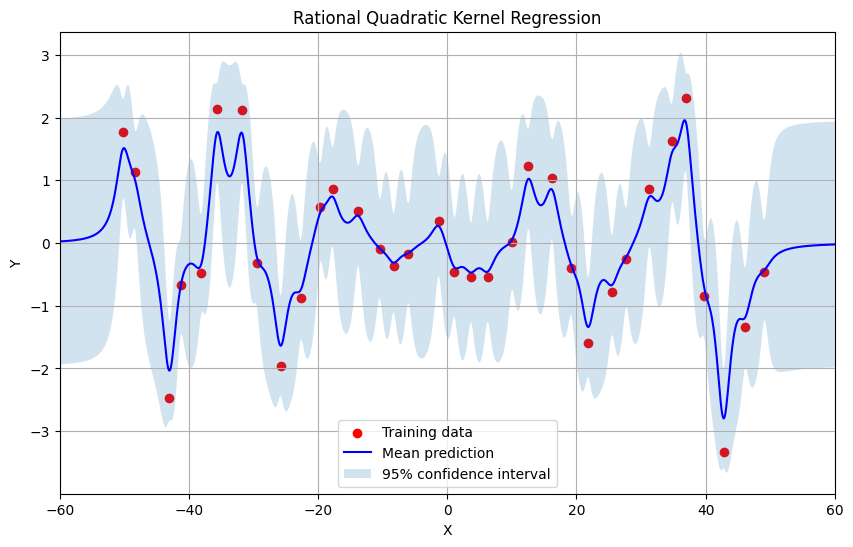

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Rational Quadratic kernel 定義
def rational_quadratic_kernel(X1, X2, length_scale=1.0, alpha=1.0, variance=1.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1,1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return variance * (1 + sqdist / (2 * alpha * length_scale**2)) ** (-alpha)

# Gaussian Process Regression 函數
def gaussian_process(X_train, y_train, X_test, length_scale=1.0, alpha=1.0, variance=1.0, noise=1e-10):

    X_train = np.asarray(X_train).reshape(-1, 1)
    y_train = np.asarray(y_train).ravel()
    X_test = np.asarray(X_test).reshape(-1, 1)

    # 計算核矩陣
    K = rational_quadratic_kernel(X_train, X_train, length_scale, alpha, variance) + noise * np.eye(len(X_train))
    K_s = rational_quadratic_kernel(X_train, X_test, length_scale, alpha, variance)
    K_ss = rational_quadratic_kernel(X_test, X_test, length_scale, alpha, variance) + noise

    K_inv = np.linalg.inv(K)

    mu = K_s.T @ K_inv @ y_train
    cov = K_ss - K_s.T @ K_inv @ K_s

    return mu.ravel(), cov

length_scale = 1.0
alpha = 1.0
variance = 1.0
noise = 1/5

X_pred = np.linspace(-60, 60, 1000).reshape(-1, 1)
mu, cov = gaussian_process(X_train, y_train, X_pred,
                           length_scale=length_scale, alpha=alpha,
                           variance=variance, noise=noise)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='red', label='Training data')
plt.plot(X_pred, mu, color='blue', label='Mean prediction')
plt.fill_between(X_pred.ravel(),
                 mu - 1.96 * np.sqrt(np.diag(cov)),
                 mu + 1.96 * np.sqrt(np.diag(cov)),
                 alpha=0.2, label='95% confidence interval')
plt.title('Rational Quadratic Kernel Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-60, 60)
plt.legend()
plt.grid(True)
plt.show()


Optimized parameters:
Length scale: 3.40288234350485
Alpha: 4363.3237921352
Variance: 1.6995405982862835
Noise: 0.23666818801559497


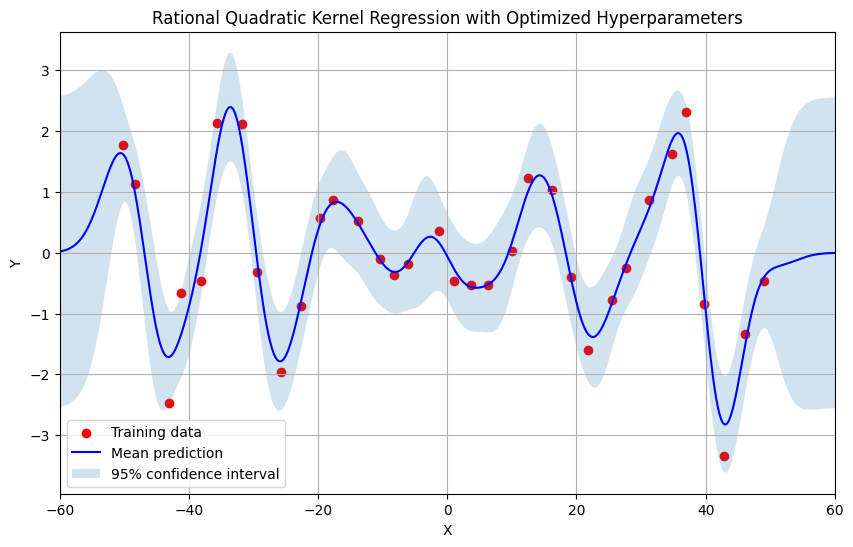

In [12]:

from scipy.optimize import minimize
import numpy as np

def negative_log_likelihood(log_params, X_train, y_train):
    length_scale, alpha, variance, noise = np.exp(log_params)
    K = rational_quadratic_kernel(X_train, X_train, length_scale, alpha, variance) + np.eye(len(X_train)) * noise

    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return np.inf  # matrix not positive definite

    alpha_vec = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    log_det = 2 * np.sum(np.log(np.diag(L)))
    nll = 0.5 * y_train.T @ alpha_vec + 0.5 * log_det + 0.5 * len(y_train) * np.log(2 * np.pi)
    return nll

init_log_params = np.log([1.0, 1.0, 1.0, 1/5])  # [length_scale, alpha, variance, noise]

res = minimize(negative_log_likelihood,
               init_log_params,
               args=(X_train, y_train),
               method='L-BFGS-B')

print("Optimized parameters:")
print("Length scale:", np.exp(res.x[0]))
print("Alpha:", np.exp(res.x[1]))
print("Variance:", np.exp(res.x[2]))
print("Noise:", np.exp(res.x[3]))

opt_length_scale, opt_alpha, opt_variance, opt_noise = np.exp(res.x)

length_scale = opt_length_scale
alpha = opt_alpha
variance = opt_variance
noise = opt_noise

X_pred = np.linspace(-60, 60, 1000).reshape(-1, 1)

mu, cov = gaussian_process(X_train, y_train, X_pred,
                           length_scale=length_scale, alpha=alpha,
                           variance=variance, noise=noise)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='red', label='Training data')
plt.plot(X_pred, mu, color='blue', label='Mean prediction')
plt.fill_between(X_pred.ravel(),
                 mu - 1.96 * np.sqrt(np.diag(cov)),
                 mu + 1.96 * np.sqrt(np.diag(cov)),
                 alpha=0.2, label='95% confidence interval')
plt.title('Rational Quadratic Kernel Regression with Optimized Hyperparameters')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-60, 60)
plt.legend()
plt.grid(True)
plt.show()

